In [33]:
#@title 开始之前
# 安装项目所需依赖库
!pip install flask werkzeug requests tornado Pillow pysnooper opencv-python numpy scipy matplotlib scikit-image scikit-learn ipython pyyaml visualdl tqdm filelock scipy prettytable torch torchvision

In [34]:
#@title 加载项目
# 维护：蒋李雾龙

import torch 
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.hub.load("bryandlee/animegan2-pytorch:main", "generator", device=device).eval()
face2paint = torch.hub.load("bryandlee/animegan2-pytorch:main", "face2paint", device=device, side_by_side=True)

Using cache found in /root/.cache/torch/hub/bryandlee_animegan2-pytorch_main
Using cache found in /root/.cache/torch/hub/bryandlee_animegan2-pytorch_main


In [35]:
#@title 加载所需方法

import os
import dlib
import collections
from typing import Union, List
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def get_dlib_face_detector(predictor_path: str = "shape_predictor_68_face_landmarks.dat"):

    if not os.path.isfile(predictor_path):
        model_file = "shape_predictor_68_face_landmarks.dat.bz2"
        os.system(f"wget http://dlib.net/files/{model_file}")
        os.system(f"bzip2 -dk {model_file}")

    detector = dlib.get_frontal_face_detector()
    shape_predictor = dlib.shape_predictor(predictor_path)

    def detect_face_landmarks(img: Union[Image.Image, np.ndarray]):
        if isinstance(img, Image.Image):
            img = np.array(img)
        faces = []
        dets = detector(img)
        for d in dets:
            shape = shape_predictor(img, d)
            faces.append(np.array([[v.x, v.y] for v in shape.parts()]))
        return faces
    
    return detect_face_landmarks


def display_facial_landmarks(
    img: Image, 
    landmarks: List[np.ndarray],
    fig_size=[15, 15]
):
    plot_style = dict(
        marker='o',
        markersize=4,
        linestyle='-',
        lw=2
    )
    pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
    pred_types = {
        'face': pred_type(slice(0, 17), (0.682, 0.780, 0.909, 0.5)),
        'eyebrow1': pred_type(slice(17, 22), (1.0, 0.498, 0.055, 0.4)),
        'eyebrow2': pred_type(slice(22, 27), (1.0, 0.498, 0.055, 0.4)),
        'nose': pred_type(slice(27, 31), (0.345, 0.239, 0.443, 0.4)),
        'nostril': pred_type(slice(31, 36), (0.345, 0.239, 0.443, 0.4)),
        'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
        'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
        'lips': pred_type(slice(48, 60), (0.596, 0.875, 0.541, 0.3)),
        'teeth': pred_type(slice(60, 68), (0.596, 0.875, 0.541, 0.4))
    }

    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis('off')

    for face in landmarks:
        for pred_type in pred_types.values():
            ax.plot(
                face[pred_type.slice, 0],
                face[pred_type.slice, 1],
                color=pred_type.color, **plot_style
            )
    plt.show()



import PIL.Image
import PIL.ImageFile
import numpy as np
import scipy.ndimage


def align_and_crop_face(
    img: Image.Image,
    landmarks: np.ndarray,
    expand: float = 1.0,
    output_size: int = 1024, 
    transform_size: int = 4096,
    enable_padding: bool = True,
):
    # Parse landmarks.
    # pylint: disable=unused-variable
    lm = landmarks
    lm_chin          = lm[0  : 17]  # left-right
    lm_eyebrow_left  = lm[17 : 22]  # left-right
    lm_eyebrow_right = lm[22 : 27]  # left-right
    lm_nose          = lm[27 : 31]  # top-down
    lm_nostrils      = lm[31 : 36]  # top-down
    lm_eye_left      = lm[36 : 42]  # left-clockwise
    lm_eye_right     = lm[42 : 48]  # left-clockwise
    lm_mouth_outer   = lm[48 : 60]  # left-clockwise
    lm_mouth_inner   = lm[60 : 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left     = np.mean(lm_eye_left, axis=0)
    eye_right    = np.mean(lm_eye_right, axis=0)
    eye_avg      = (eye_left + eye_right) * 0.5
    eye_to_eye   = eye_right - eye_left
    mouth_left   = lm_mouth_outer[0]
    mouth_right  = lm_mouth_outer[6]
    mouth_avg    = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    x *= expand
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, PIL.Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    if output_size < transform_size:
        img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

    return img

In [36]:
! pip install paddlepaddle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
!pip install paddleseg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
!git clone https://github.com/PaddlePaddle/PaddleSeg.git

Cloning into 'PaddleSeg'...
remote: Enumerating objects: 20562, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 20562 (delta 3), reused 2 (delta 1), pack-reused 20549
Receiving objects: 100% (20562/20562), 345.93 MiB | 24.23 MiB/s, done.
Resolving deltas: 100% (13399/13399), done.


In [39]:
%cd PaddleSeg/contrib/PP-HumanSeg/

/content/PaddleSeg/contrib/PP-HumanSeg/src/PaddleSeg/contrib/PP-HumanSeg


In [40]:
# 执行以下脚本下载所有Inference Model
!python src/download_inference_models.py

Connecting to https://paddleseg.bj.bcebos.com/dygraph/pp_humanseg_v2/portrait_pp_humansegv1_lite_398x224_inference_model_with_softmax.zip
[==================================================] 100.00%
Uncompress portrait_pp_humansegv1_lite_398x224_inference_model_with_softmax.zip
[==================================================] 100.00%
Connecting to https://paddleseg.bj.bcebos.com/dygraph/pp_humanseg_v2/portrait_pp_humansegv2_lite_256x144_smaller/portrait_pp_humansegv2_lite_256x144_inference_model_with_softmax.zip
[==================================================] 100.00%
Uncompress portrait_pp_humansegv2_lite_256x144_inference_model_with_softmax.zip
[==================================================] 100.00%
Connecting to https://paddleseg.bj.bcebos.com/dygraph/pp_humanseg_v2/human_pp_humansegv1_lite_192x192_inference_model_with_softmax.zip
[==================================================] 100.00%
Uncompress human_pp_humansegv1_lite_192x192_inference_model_with_softmax.zip
[==

In [41]:
# 可选
# 下载测试数据集
# !python src/download_data.py

Connecting to https://paddleseg.bj.bcebos.com/humanseg/data/mini_supervisely.zip
[=                                                 ] 3.89%Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 362, in _error_catcher
    yield
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 444, in read
    data = self._fp.read(amt)
  File "/usr/lib/python3.7/http/client.py", line 465, in read
    n = self.readinto(b)
  File "/usr/lib/python3.7/http/client.py", line 509, in readinto
    n = self.fp.readinto(b)
  File "/usr/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.7/ssl.py", line 1071, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.7/ssl.py", line 929, in read
    return self._sslobj.read(len, buffer)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "s

In [42]:
%cd src

/content/PaddleSeg/contrib/PP-HumanSeg/src/PaddleSeg/contrib/PP-HumanSeg/src


In [43]:
# ima_path与bg_img_path应为自己的图片路径，注意根据演示路径替换自己本地的路径
args = {   'config': '/content/PaddleSeg/contrib/PP-HumanSeg/inference_models/portrait_pp_humansegv2_lite_256x144_inference_model_with_softmax/deploy.yaml',
        'img_path': '/content/PaddleSeg/contrib/PP-HumanSeg/src/1.jpg',
        'bg_img_path': '/content/PaddleSeg/contrib/PP-HumanSeg/data/images/2.jpg',
        'save_dir': '/content/PaddleSeg/contrib/PP-HumanSeg/data/1.jpg',
        'use_gpu': True,
        'test_speed' : False,
        'use_optic_flow' : False,
        'use_post_process' : False
        }

In [44]:
# 先动漫化后增加背景效果更佳
import requests

# 加载网络或本地文件
img = Image.open(args['img_path']).convert("RGB")
# img = Image.open("/content/sample.jpg").convert("RGB")

face_detector = get_dlib_face_detector()
landmarks = face_detector(img)
for landmark in landmarks:
    face = align_and_crop_face(img, landmark, expand=1.3)
    p_face = face2paint(model=model, img=face, size=512)
    # display(p_face)
    # p_face.save('1.png') # 此输出为对比图片
    # 裁剪为需要的部分输出
    x_, y_ = p_face.size
    out = p_face.crop((int(x_/2), 0, x_, y_))
    # display(out)
    out.save(args['img_path'])

In [48]:
import argparse
import os
import sys

import cv2
import numpy as np
from tqdm import tqdm

# __dir__ = os.path.dirname(os.path.abspath(__file__))
# sys.path.append(os.path.abspath(os.path.join(__dir__, '../../../')))
from paddleseg.utils import get_sys_env, logger, get_image_list

import codecs
import os
import sys
import time

import yaml
import numpy as np
import cv2
import paddle
from paddle.inference import create_predictor, PrecisionType
from paddle.inference import Config as PredictConfig


import paddleseg.transforms as T
from paddleseg.core.infer import reverse_transform
from paddleseg.cvlibs import manager
from paddleseg.utils import TimeAverager

from optic_flow_process import optic_flow_process

from PIL import Image


def get_bg_img(bg_img_path, img_shape):
    if bg_img_path is None:
        bg = 255 * np.ones(img_shape)
    elif not os.path.exists(bg_img_path):
        raise Exception('The --bg_img_path is not existed: {}'.format(
            bg_img_path))
    else:
        bg = cv2.imread(bg_img_path)
    return bg


def makedirs(save_dir):
    dirname = save_dir if os.path.isdir(save_dir) else \
        os.path.dirname(save_dir)
    if not os.path.exists(dirname):
        os.makedirs(dirname)


def seg_image(args):
    print(args)
    assert os.path.exists(args['img_path']), \
        "The --img_path is not existed: {}.".format(args['img_path'])

    logger.info("Input: image")
    logger.info("Create predictor...")
    predictor = Predictor(args)

    logger.info("Start predicting...")
    img = cv2.imread(args['img_path'])
    bg_img = get_bg_img(args['bg_img_path'], img.shape)
    out_img = predictor.run(img, bg_img)
    cv2.imwrite(args['save_dir'], out_img)
    im = Image.open(args['save_dir'])  
    display(im)

class Predictor:
    def __init__(self, args):
        self.args = args
        self.cfg = DeployConfig(args['config'], False)
        self.compose = T.Compose(self.cfg.transforms)

        pred_cfg = PredictConfig(self.cfg.model, self.cfg.params)
        pred_cfg.disable_glog_info()
        if self.args['use_gpu']:
            pred_cfg.enable_use_gpu(100, 0)

        self.predictor = create_predictor(pred_cfg)
        if self.args['test_speed']:
            self.cost_averager = TimeAverager()

        if args['use_optic_flow']:

            self.disflow = cv2.DISOpticalFlow_create(
                cv2.DISOPTICAL_FLOW_PRESET_ULTRAFAST)
            width, height = self.cfg.target_size()
            self.prev_gray = np.zeros((height, width), np.uint8)
            self.prev_cfd = np.zeros((height, width), np.float32)
            self.is_first_frame = True

    def run(self, img, bg):
        input_names = self.predictor.get_input_names()
        input_handle = self.predictor.get_input_handle(input_names[0])

        data = self.compose({'img': img})
        input_data = np.array([data['img']])

        input_handle.reshape(input_data.shape)
        input_handle.copy_from_cpu(input_data)
        if self.args['test_speed']:
            start = time.time()

        self.predictor.run()

        if self.args['test_speed']:
            self.cost_averager.record(time.time() - start)
        output_names = self.predictor.get_output_names()
        output_handle = self.predictor.get_output_handle(output_names[0])
        output = output_handle.copy_to_cpu()

        return self.postprocess(output, img, data, bg)

    def postprocess(self, pred_img, origin_img, data, bg):
        trans_info = data['trans_info']
        score_map = pred_img[0, 1, :, :]

        # post process
        if self.args['use_post_process']:
            mask_original = score_map.copy()
            mask_original = (mask_original * 255).astype("uint8")
            _, mask_thr = cv2.threshold(mask_original, 240, 1,
                                        cv2.THRESH_BINARY)
            kernel_erode = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
            kernel_dilate = cv2.getStructuringElement(cv2.MORPH_CROSS, (25, 25))
            mask_erode = cv2.erode(mask_thr, kernel_erode)
            mask_dilate = cv2.dilate(mask_erode, kernel_dilate)
            score_map *= mask_dilate

        # optical flow
        if self.args['use_optic_flow']:
            score_map = 255 * score_map
            cur_gray = cv2.cvtColor(origin_img, cv2.COLOR_BGR2GRAY)
            cur_gray = cv2.resize(cur_gray,
                                  (pred_img.shape[-1], pred_img.shape[-2]))
            optflow_map = optic_flow_process(cur_gray, score_map, self.prev_gray, self.prev_cfd, \
                    self.disflow, self.is_first_frame)
            self.prev_gray = cur_gray.copy()
            self.prev_cfd = optflow_map.copy()
            self.is_first_frame = False
            score_map = optflow_map / 255.

        score_map = score_map[np.newaxis, np.newaxis, ...]
        score_map = reverse_transform(
            paddle.to_tensor(score_map), trans_info, mode='bilinear')
        alpha = np.transpose(score_map.numpy().squeeze(1), [1, 2, 0])

        h, w, _ = origin_img.shape
        bg = cv2.resize(bg, (w, h))
        if bg.ndim == 2:
            bg = bg[..., np.newaxis]

        out = (alpha * origin_img + (1 - alpha) * bg).astype(np.uint8)
        return out

class DeployConfig:
    def __init__(self, path, vertical_screen):
        with codecs.open(path, 'r', 'utf-8') as file:
            self.dic = yaml.load(file, Loader=yaml.FullLoader)

            [width, height] = self.dic['Deploy']['transforms'][0]['target_size']
            if vertical_screen and width > height:
                self.dic['Deploy']['transforms'][0][
                    'target_size'] = [height, width]

        self._transforms = self._load_transforms(self.dic['Deploy'][
            'transforms'])
        self._dir = os.path.dirname(path)

    @property
    def transforms(self):
        return self._transforms

    @property
    def model(self):
        return os.path.join(self._dir, self.dic['Deploy']['model'])

    @property
    def params(self):
        return os.path.join(self._dir, self.dic['Deploy']['params'])

    def target_size(self):
        [width, height] = self.dic['Deploy']['transforms'][0]['target_size']
        return [width, height]

    def _load_transforms(self, t_list):
        com = manager.TRANSFORMS
        transforms = []
        for t in t_list:
            ctype = t.pop('type')
            transforms.append(com[ctype](**t))

        return transforms






{'config': '/content/PaddleSeg/contrib/PP-HumanSeg/inference_models/portrait_pp_humansegv2_lite_256x144_inference_model_with_softmax/deploy.yaml', 'img_path': '/content/PaddleSeg/contrib/PP-HumanSeg/src/1.jpg', 'bg_img_path': '/content/PaddleSeg/contrib/PP-HumanSeg/data/images/2.jpg', 'save_dir': '/content/PaddleSeg/contrib/PP-HumanSeg/data/1.jpg', 'use_gpu': True, 'test_speed': False, 'use_optic_flow': False, 'use_post_process': False}
2022-09-28 08:29:55 [INFO]	Input: image
2022-09-28 08:29:55 [INFO]	Create predictor...
2022-09-28 08:29:56 [INFO]	Start predicting...


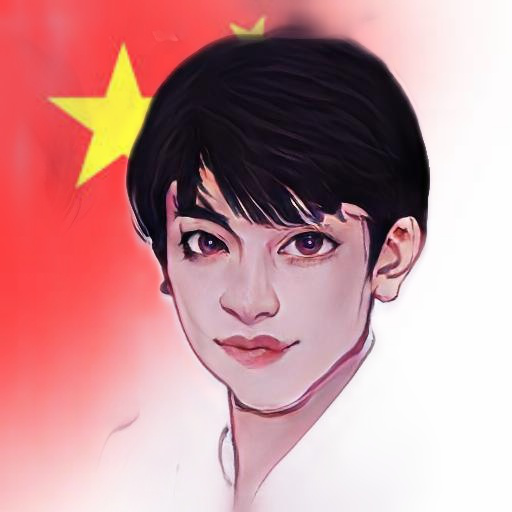

In [49]:
seg_image(args)

In [47]:
%pwd

'/content/PaddleSeg/contrib/PP-HumanSeg/src/PaddleSeg/contrib/PP-HumanSeg/src'